In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import datetime
from torch import nn
from torch.utils.data import dataloader
from methods import *

In [38]:
data = pd.read_csv("voxmeter.csv")
data

,party_letter,votes,date
0,A,19.9,2025-11-16
1,B,6.2,2025-11-16
2,C,7.2,2025-11-16
3,F,12.1,2025-11-16
4,H,2.1,2025-11-16
5,I,11.4,2025-11-16
6,M,2.9,2025-11-16
7,O,8.3,2025-11-16
8,V,10.4,2025-11-16
9,Æ,9.2,2025-11-16


,party_letter,votes,date
0,A,19.9,2025-11-16
12,A,19.3,2025-11-23
24,A,19.4,2025-11-30
36,A,18.0,2025-12-07
48,A,18.6,2025-12-14


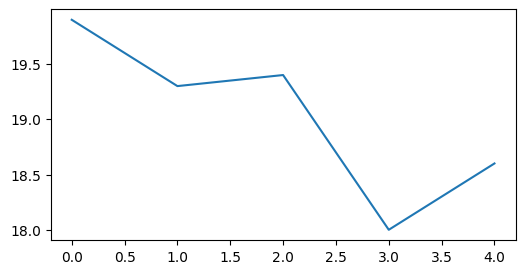

In [39]:
_party = party(data, "A")
data = _party.party_data
votes = data.get("votes").to_list()
display(data)
plt.figure(figsize=[6, 3])
plt.plot(range(len(votes)), votes)
plt.show()

In [40]:
X_train = torch.tensor(votes[:len(data)-2])
y_train = torch.tensor(votes[1:len(data)-1])
X_test = torch.tensor(votes[1:len(data)-1])
y_test = torch.tensor(votes[len(data)-1])
print(f"X_train length: {len(X_train)}")
print(f"y_train length: {len(y_train)}")
print(f"X_test length: {X_test.numel()}")
print(f"y_test length: {y_test.numel()}")

X_train length: 3
y_train length: 3
X_test length: 3
y_test length: 1


In [41]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)\

seq_length = len(X_train)-1
X, y = create_sequences(X_train.numpy(), seq_length)

trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [42]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last time step
        return out, hn, cn

In [43]:
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [44]:
num_epochs = 100
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0, c0 = h0.detach(), c0.detach()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 111.5086
Epoch [20/100], Loss: 12.9325
Epoch [30/100], Loss: 1.0464
Epoch [40/100], Loss: 4.2126
Epoch [50/100], Loss: 0.7361
Epoch [60/100], Loss: 0.0926
Epoch [70/100], Loss: 0.2130
Epoch [80/100], Loss: 0.0061
Epoch [90/100], Loss: 0.0197
Epoch [100/100], Loss: 0.0050


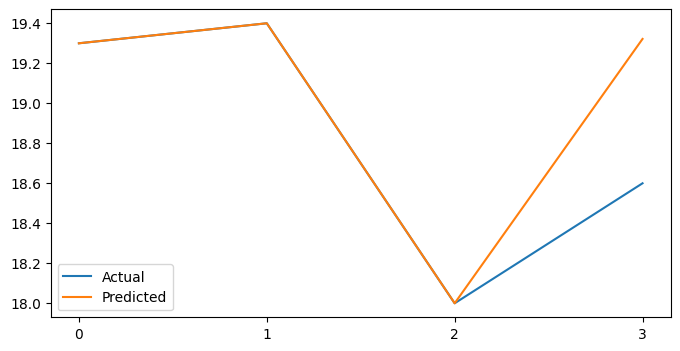

Predicted Vote: 19.32
Actual Vote: 18.60
MSE: 0.521


In [45]:
model.eval()

# Reshape X_test to (Batch Size, Sequence Length, Features)
testX = X_test.view(1, -1, 1).float()

with torch.no_grad():
    y_pred, _, _ = model(testX)

plt.figure(figsize=[8, 4])
plt.plot(range(len(X_test)+1), torch.cat([X_test, y_test.unsqueeze(0)]), label="Actual")
plt.plot(range(len(X_test)+1), torch.cat([X_test, y_pred.flatten()]), label="Predicted")
plt.xticks(range(len(X_test)+1))
plt.legend()
plt.show()

print(f"Predicted Vote: {y_pred.item():.2f}")
print(f"Actual Vote: {y_test.item():.2f}")
print(f"MSE: {(y_pred.item()-y_test.item())**2:.3f}")